In [1]:
from utils import *

import time
import numpy as np
import pandas as pd

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

In [4]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [5]:
dataset_ex_df = pd.read_csv('data/adjclose_2020-03-08_2021-03-08_4638', header=0, parse_dates=[0], date_parser=parser)

In [6]:
dataset_ex_df

,date,A,AA,AACG,AAIC,AAL,AAMC,AAME,AAOI,AAON,...,ZS,ZSAN,ZTO,ZTS,ZUMZ,ZUO,ZVO,ZYME,ZYNE,ZYXI
0,2020-03-09,70.180687,8.69,0.97,4.97,14.750000,20.510000,2.55,7.720,51.352589,...,43.939999,0.630,26.757671,129.167542,24.320000,10.310,1.45,36.410000,3.46,12.410
1,2020-03-10,72.323303,9.26,0.98,4.94,17.000000,19.940001,2.60,8.120,51.630814,...,47.009998,0.571,27.400650,132.154755,22.100000,11.030,1.32,35.200001,3.82,11.900
2,2020-03-11,68.286049,9.20,0.96,4.44,16.260000,19.940001,2.58,7.040,43.939850,...,42.880001,0.566,27.202810,129.715210,20.940001,9.960,1.31,32.259998,3.89,11.090
3,2020-03-12,62.909668,7.51,0.90,3.16,13.450000,17.480000,2.52,5.680,41.008541,...,39.500000,0.472,25.610209,119.767746,18.360001,8.590,1.31,28.740000,3.34,9.160
4,2020-03-13,68.643150,8.00,0.86,3.34,14.310000,15.930000,2.50,6.110,51.769924,...,41.889999,0.471,25.323343,124.945602,19.160000,7.690,1.40,28.969999,3.32,9.990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2021-03-01,124.480003,25.99,5.15,4.06,21.180000,23.639999,4.76,9.020,77.379997,...,210.160004,1.330,35.220001,157.690002,47.060001,15.500,5.19,36.770000,4.66,14.690
247,2021-03-02,123.639999,27.50,5.07,4.08,21.440001,24.000000,4.70,8.625,74.919998,...,202.610001,1.250,35.060001,157.050003,46.540001,15.290,5.29,36.610001,4.68,14.250
248,2021-03-03,119.300003,30.83,4.63,4.01,22.170000,23.049999,4.43,8.360,74.089996,...,187.830002,1.220,34.799999,149.320007,46.330002,15.000,5.09,34.160000,4.51,14.250
249,2021-03-04,119.300003,30.83,4.63,4.01,22.170000,23.049999,4.43,8.360,74.089996,...,188.960007,1.170,35.439999,147.960007,47.029999,14.955,5.09,34.500000,4.51,14.145


In [7]:
dataset_ex_df = pd.DataFrame(dataset_ex_df[['date', 'INTT']])

In [8]:
#dataset_ex_df.rename(columns={"INTT": "price"}, inplace=True)

In [9]:
dataset_ex_df

,date,INTT
0,2020-03-09,3.69
1,2020-03-10,3.67
2,2020-03-11,3.37
3,2020-03-12,3.00
4,2020-03-13,2.56
...,...,...
246,2021-03-01,8.73
247,2021-03-02,8.55
248,2021-03-03,8.78
249,2021-03-04,8.78


In [10]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 251 number of days in the dataset.


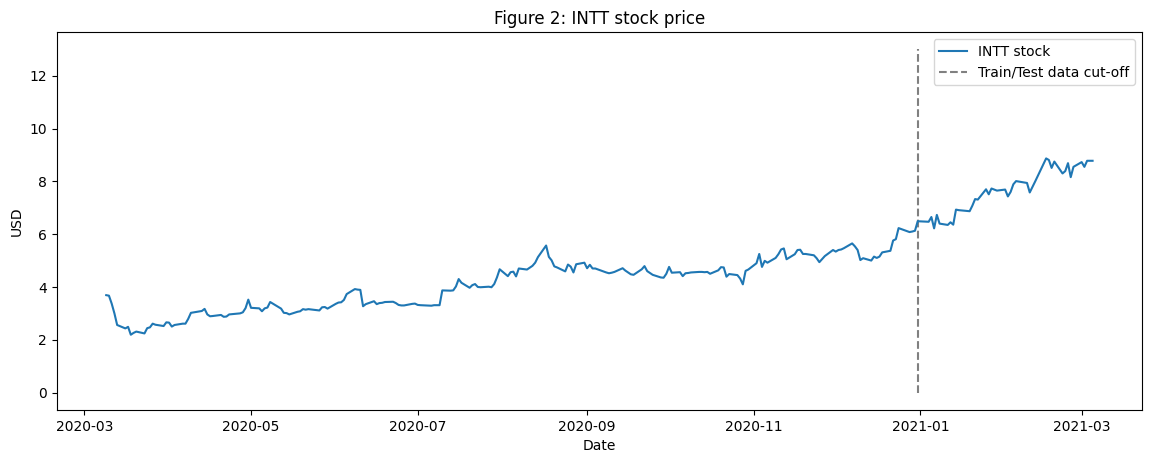

In [11]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['date'], dataset_ex_df['INTT'], label='INTT stock')
plt.vlines(datetime.date(2020,12, 31), 0, 13, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: INTT stock price')
plt.legend()
plt.show()

In [12]:
num_training_days = int(dataset_ex_df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_ex_df.shape[0]-num_training_days))

Number of training days: 175. Number of test days: 76.


In [13]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['INTT'].rolling(window=7).mean()
    dataset['ma21'] = dataset['INTT'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = pd.ewma(dataset['INTT'], span=26)
    dataset['12ema'] = pd.ewma(dataset['INTT'], span=12)
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = pd.stats.moments.rolling_std(dataset['price'],20)
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['INTT'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['INTT']-1
    
    return dataset

In [14]:
dataset_TI_df = get_technical_indicators(dataset_ex_df[['INTT']])

AttributeError: module 'pandas' has no attribute 'ewma'